# Super Continuum Generation in $\chi^{(2)}$ materials

Author: Luis Ledezma (ledezma@caltech.edu)

Let's change the input pulse to match JPL's EO comb.

## The code

We begin by importing the modules needed, including my own. I also do some formatting. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc

#This are my libraries
import nlo
import pulses
import materials
import waveguides

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

In [3]:
wl_ff = 1559*nm #Fundamental wavelength
f0_ff = c/wl_ff

#Let's set the bandwdith
f_max = c/(300*nm)
f_min = c/(3*um)
BW = f_max - f_min 

#Now we can create the time and frequency arrays
NFFT = 2**14
Tmax = NFFT/BW
dt = 1/BW
t_start = -3*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f_ref_index = np.abs(f).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/um))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for reference = %i' %(f_ref_index))

Fundamental wavelength = 1559.0 nm
Fundamental frequency = 192.3 THz
Simulation bandwidth = 899.4 THz
Time window size = 18.217 ps
Sampling Rate = 1.112 fs
Frequency Resolution = 54.894 GHz
Reference wavelength = 545.5 nm
Reference frequency = 549.6 THz
Minimum absolute frequency = 99.9 THz
Maximum absolute frequency = 999.3 THz
Minimum absolute wavelength = 300.0 nm
Maximum absolute wavelength = 3.0 um
Array index for fundamental = 9875
Array index for reference = 0


## Waveguide

In [5]:
width = 1000*nm
hLN = 700*nm
hetch = 500*nm
wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)

neff = np.zeros(wl_abs.shape)
for kw in range(wl_abs.size):
    try:
        neff[kw] = wg.neff(wl_abs[kw])
    except ValueError:
        print('Failed at wavelength = %0.1f nm' %(wl_abs[kw]/nm))

def n_func(wl):
    return neff

Refractive index at fundamental = 1.920


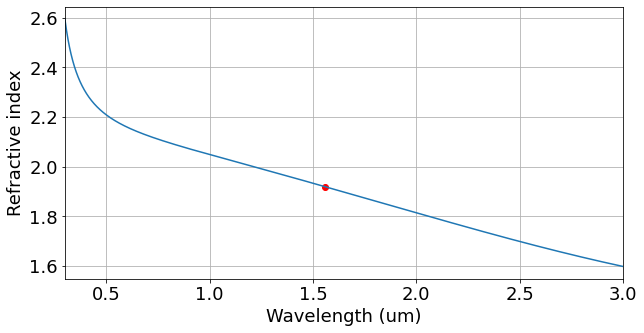

In [6]:
n = n_func(wl_abs)
nw = n[f0_ff_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(n))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

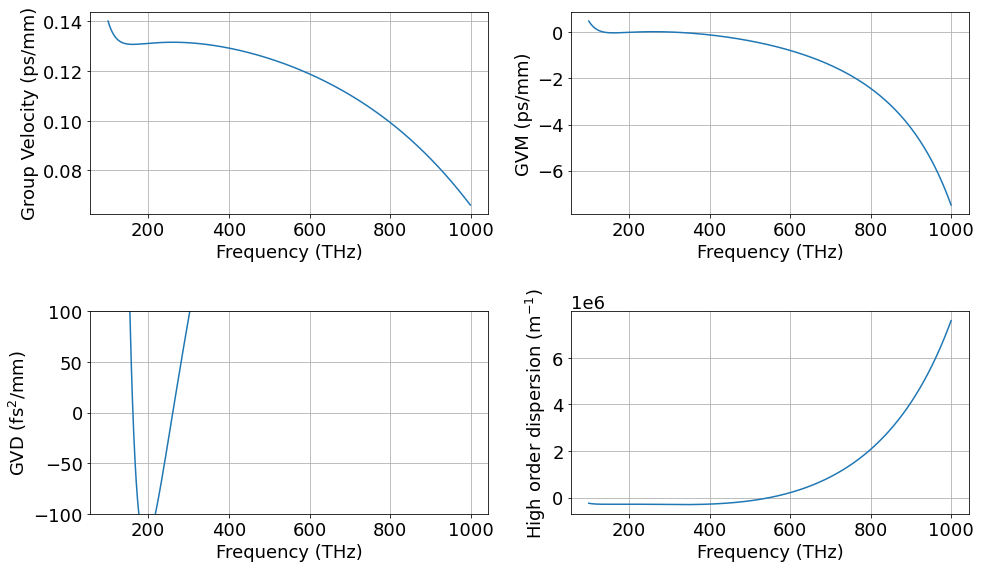

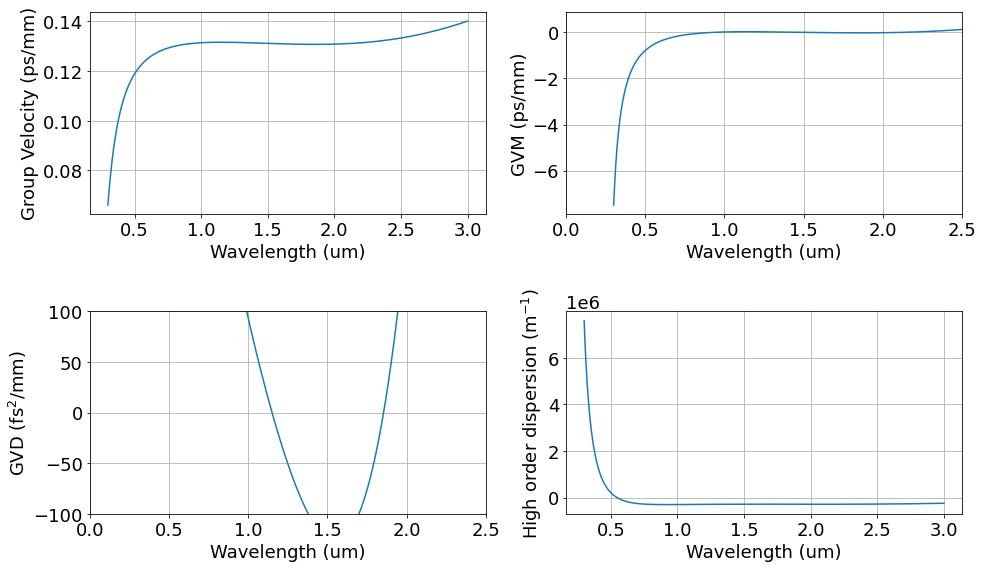

In [7]:
beta = omega_abs*n/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
f_v_ref = f0_ff
f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
v_ref = vg[f_v_ref_index]
D = beta - beta_ref - Omega/v_ref
GVM = 1/v_ref - 1/vg

plt.rcParams['figure.figsize'] = [14, 16]
fig = plt.figure()
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)

ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Frequency (THz)');

ax2.plot(fftshift(f_abs)/THz, fftshift(GVM)/(ps/mm));
ax2.set_ylabel('GVM (ps/mm)'); ax2.set_xlabel('Frequency (THz)');

ax3.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax3.set_ylabel('GVD (fs$^2$/mm)'); ax3.set_xlabel('Frequency (THz)');

ax4.plot(fftshift(f_abs)/THz, fftshift(D));
ax4.set_xlabel('Frequency (THz)'); ax4.set_ylabel('High order dispersion (m$^{-1}$)');

ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);
ax3.set_ylim([-100,100])
fig.tight_layout()

fig = plt.figure()
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)

ax1.plot(fftshift(wl_abs)/um, fftshift(vg)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Wavelength (um)');

ax2.plot(fftshift(wl_abs)/um, fftshift(GVM)/(ps/mm));
ax2.set_ylabel('GVM (ps/mm)'); ax2.set_xlabel('Wavelength (um)');

ax3.plot(fftshift(wl_abs)/um, fftshift(beta_2)/(fs**2/mm));
ax3.set_ylabel('GVD (fs$^2$/mm)'); ax3.set_xlabel('Wavelength (um)');

ax4.plot(fftshift(wl_abs)/um, fftshift(D));
ax4.set_xlabel('Wavelength (um)'); ax4.set_ylabel('High order dispersion (m$^{-1}$)');

ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

ax2.set_xlim([0,2.5])
ax3.set_xlim([0,2.5])
ax3.set_ylim([-100,100])

fig.tight_layout()

## Component Length

In [8]:
L = 10*mm

f0_sh_index = np.abs(f + f_ref - 2*f0_ff).argmin()

print('GVM (shg) = %0.1f ps/mm' % (GVM[f0_sh_index]/(ps/mm)))
print('Walk-off (shg) = %0.1f ps' % (6*GVM[f0_sh_index]/(ps/mm)))
print('GVD at fund = %0.1f fs^2/mm'% (beta_2[f0_ff_index]/(fs*fs/mm)))
print('GVD at sh = %0.1f fs^2/mm'% (beta_2[f0_sh_index]/(fs*fs/mm)))

GVM (shg) = -0.1 ps/mm
Walk-off (shg) = -0.5 ps
GVD at fund = -127.2 fs^2/mm
GVD at sh = 275.2 fs^2/mm


## Quasi Phase Matching

In [9]:
wl_pp = wl_ff
f1 = c/(wl_pp)
f2 = 2*f1
f1_index = np.abs(f + f_ref - f1).argmin()
f2_index = np.abs(f + f_ref - f2).argmin()

n1 = n[f1_index]
n2 = n[f2_index]

print("Poling period for second harmonic generation starting at %0.3f um = %0.3f um" %(wl_pp/um, c/f2/(n2-n1)/um))

Poling period for second harmonic generation starting at 1.559 um = 4.254 um


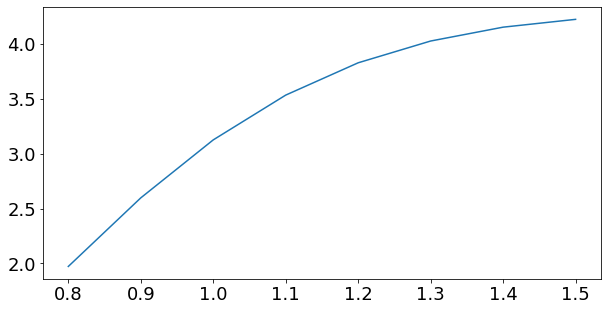

In [10]:
wl_pp_1 = 800*nm
wl_pp_2 = 1.6*um
wl_pp = np.arange(wl_pp_1, wl_pp_2, 100*nm)
pp = np.zeros(wl_pp.size)
for kp in np.arange(pp.size):
    f1 = c/wl_pp[kp]
    f2 = 2*f1
    f1_index = np.abs(f + f_ref - f1).argmin()
    f2_index = np.abs(f + f_ref - f2).argmin()
    n1 = n[f1_index]
    n2 = n[f2_index]
    pp[kp] = c/f2/(n2-n1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(wl_pp/um, pp/um)

In [11]:
pp0 = 3.0*um
ppf = 4.2*um
k0 = 2*pi/pp0
kf = 2*pi/ppf

N = 1
Xw = 2.7e-12 #Includes overlap integral and chi2 values
def chi2(z):
    phi = k0 * z + (kf - k0) * z**2 / (2 * L)
    poling = np.sign( np.cos( phi ) )
    return poling*Xw*omega_abs/(4*N)

# #PLot it to check
# z = np.arange(0, L, 0.1*um)
# chi2_plot = np.zeros_like(z)
# for kz in range(z.size):
#     chi2_plot[kz] = chi2(z[kz])[0]
    
# plt.plot(z[0:500], chi2_plot[0:500])
# # plt.xlim([0, 100*um])
# plt.figure()
# plt.plot(z[10000:10500], chi2_plot[10000:10500])

## Nonlinear  Component
Now we create a nonlinear component based on this refractive index and propagation constant. This nonlinear component implements a method for propagation using the NEE.

(-15.0, 5.0)

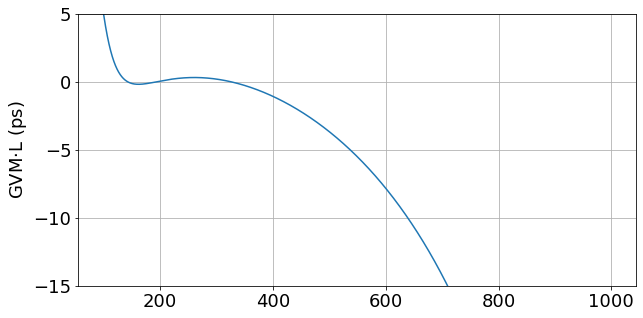

In [12]:
Alpha = 0.1# attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m
crystal = nlo.nonlinear_element(L, n_func=n_func, chi2=chi2, alpha=alpha)

#Let's also check again the GVM now that we have the crystal length
plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(fftshift(f_abs)/THz, fftshift(GVM*L)/(ps));
ax1.set_ylabel('GVM$\cdot$L (ps)'); ax2.set_xlabel('Frequency (THz)');
ax1.grid('True')
ax1.set_ylim([-15,5])

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into a single object, just like we did with ```nonlinear_element```. I also have a bunch of convenience methods associated with ```pulse``` for things like plotting, calculating FWHM, energy, etc.

Comb Average Power = 100.0 mW
Pulse Energy = 10.0 pJ


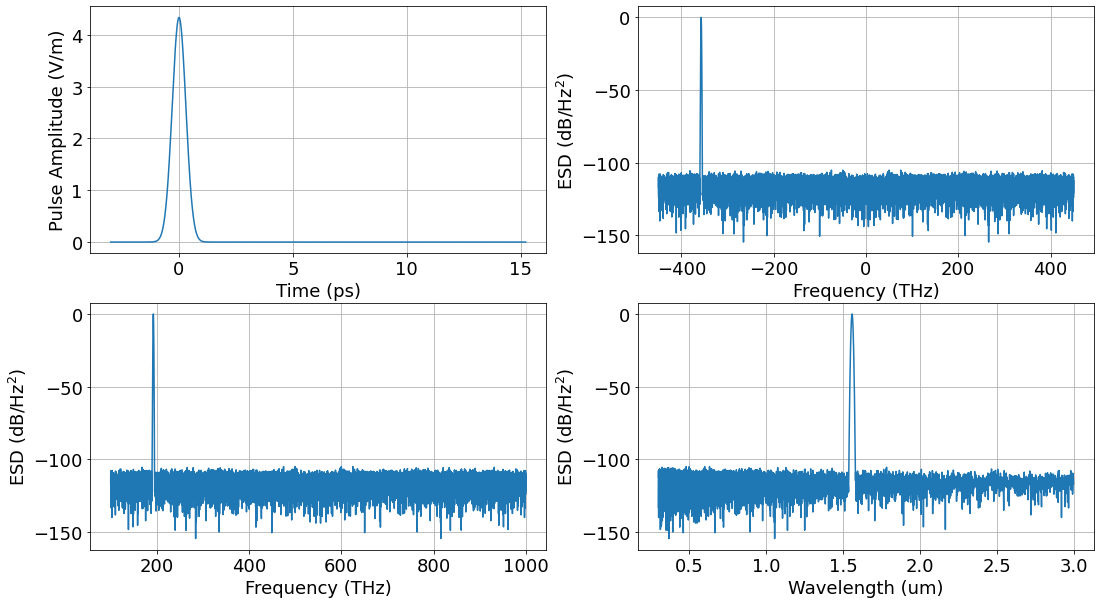

In [13]:
#Frequency offset from reference:
Omega_0 = 2*pi*(f0_ff - f_ref)

#Pulse width:
tau = 500*fs

#Peak value:
Energy = 10*pJ
Ppeak = np.sqrt((0.94*Energy/tau))
frep = 10*GHz
Pavg = Energy*frep
print('Comb Average Power = %0.1f mW' %(Pavg/mW))

#Noise floor
N_dB = 100
noise = Ppeak * 10**(-N_dB/20) * np.random.normal(size=NFFT)

#Pulse creation
x = Ppeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*Omega_0*t)
x = x + noise
a_input = pulses.pulse(t, x, wl_ref)
print('Pulse Energy = %0.1f pJ' %(a_input.energy_td()*1e12))

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = a_input.plot_mag(ax=ax1, t_unit='ps'); ax1.set_ylabel('Pulse Amplitude (V/m)')
ax2 = a_input.plot_ESD_dB(ax=ax2, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax3 = a_input.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dB/Hz$^2$)', f_unit = 'THz')
ax4 = a_input.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dB/Hz$^2$)', wl_unit='um');

## Single pass

Finally, we can run the simulation. The method ```propagate_NEE``` takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [14]:
h = min(pp0, ppf)/20
[a_output, pulse_evol_full] = crystal.propagate_NEE_fd(a_input, h, v_ref=v_ref, method='waveguide')

Crystal length = 10.00 mm
Step size = 0.15 um
Number of steps = 66666
Using method = waveguide
Completed propagation along 0.5 mm (27.2 s)
Completed propagation along 1.0 mm (14.9 s)
Completed propagation along 1.5 mm (14.9 s)
Completed propagation along 2.0 mm (14.8 s)
Completed propagation along 2.5 mm (14.8 s)
Completed propagation along 3.0 mm (14.8 s)
Completed propagation along 3.5 mm (14.9 s)
Completed propagation along 4.0 mm (14.8 s)
Completed propagation along 4.5 mm (14.8 s)
Completed propagation along 5.0 mm (14.8 s)
Completed propagation along 5.5 mm (14.8 s)
Completed propagation along 6.0 mm (14.9 s)
Completed propagation along 6.5 mm (14.9 s)
Completed propagation along 7.0 mm (14.9 s)
Completed propagation along 7.5 mm (14.9 s)
Completed propagation along 8.0 mm (14.8 s)
Completed propagation along 8.5 mm (14.9 s)
Completed propagation along 9.0 mm (14.9 s)
Completed propagation along 9.5 mm (14.9 s)
Completed propagation along 10.0 mm (14.8 s)
Total time = 309.9 s


In [15]:
print('Output Pulse Energy = %0.1f pJ' %(pulses.energy_td(t, a_output)/pJ))

Output Pulse Energy = 9.9 pJ


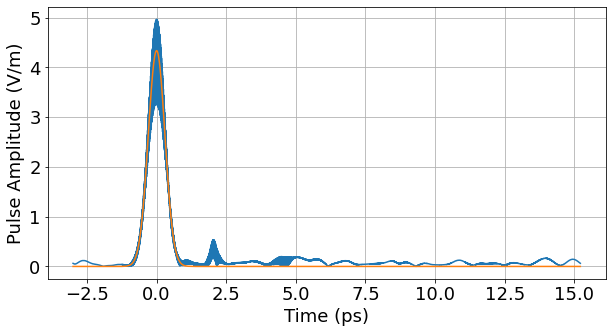

In [16]:
plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulses.plot_mag(t, a_output)
ax1 = a_input.plot_mag(ax=ax1)
# ax1.set_xlim(-2,0.5)
# ax1.set_ylim(0,2e8)
ax1.set_ylabel('Pulse Amplitude (V/m)')
ax1.set_xlabel('Time (ps)');

Text(0, 0.5, 'dB')

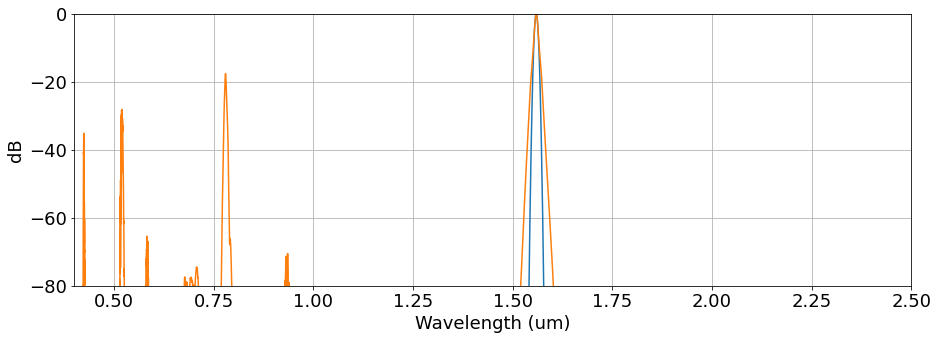

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
a_input.plot_ESD_dB_vs_wavelength(ax=ax1)
pulses.plot_ESD_dB_vs_wavelength(t, a_output, f_ref, ax=ax1)
ax1.set_xlim([0.4, 2.5])
ax1.set_ylim([-80,0])
# ax1.set_ylim([-200,0])
ax1.set_ylabel('dB')

We can also look at the evolution of the pulse along the crystal. Here it also clear that the input pulse travels while it creates a faint second harmonic that is stationary in the simulation frame. 

## Pulse evolution along the crystal

In [18]:
#Downsample evolution for plotting
Ndown = 10
pulse_evol = pulse_evol_full[::,::Ndown]
Nsteps = pulse_evol.shape[1]-1

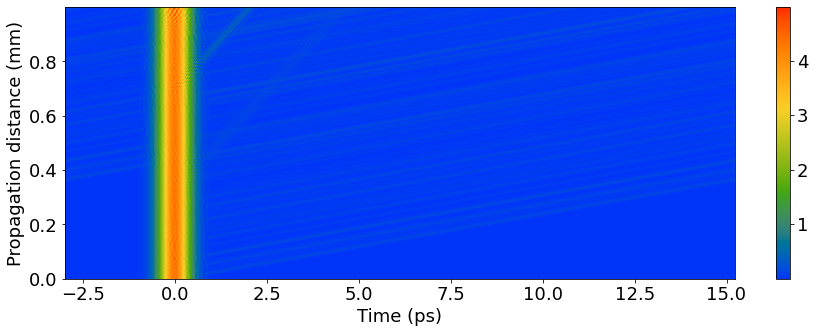

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
Nsteps = pulse_evol.shape[1]-1
X,Y = np.meshgrid(t/ps, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(pulse_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
# ax.set_ylim([0,5])
# ax.set_xlim([-2,0.5])
plt.colorbar(im, ax=ax);

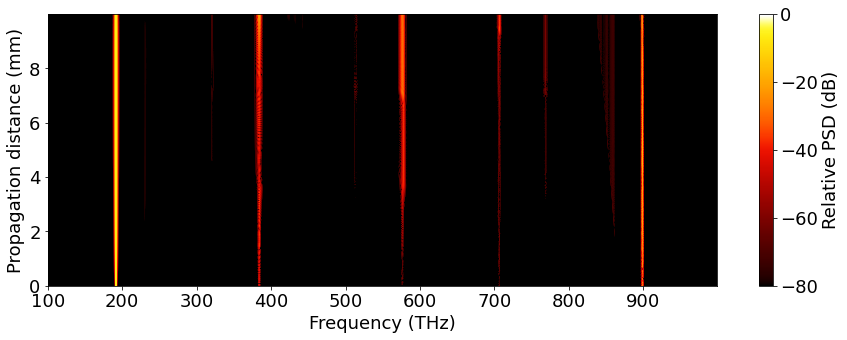

In [20]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = pulse_evol[:,k]
    _ , Aesd = pulses.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

plt.rcParams['figure.figsize'] = [15, 5]

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*Ndown/mm)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

# wl_array = c/(fftshift(f)+f_ref)*1e6
# Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
# plt.figure()
# plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
# cb = plt.colorbar()
# cb.set_label('Relative PSD (dB)')
# plt.xlabel('Wavelength (um)')
# plt.ylabel('Propagation distance (mm)');

Text(0, 0.5, 'Propagation distance (mm)')

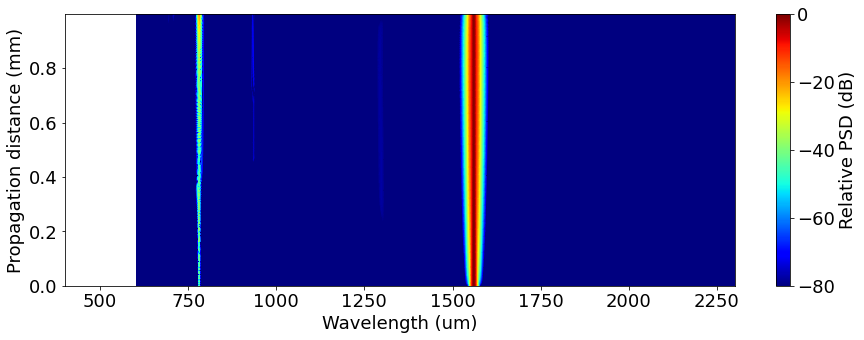

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
wl_min = 0.4
wl_max = 2.3
wl_array = c/(fftshift(f)+f_ref)*1e6
wl_max_idx = np.abs(wl_array - wl_max).argmin()
wl_min_idx = np.abs(wl_array - wl_min).argmin()
wl_array = wl_array[wl_max_idx:wl_min_idx]*1e3
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
# plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol[wl_max_idx:, :])), cmap = cc.cm["fire"], vmin=-80, vmax=0)
plt.pcolormesh(Xwl[::4,::], Ywl[::4,::], (np.transpose(A_evol[wl_max_idx:wl_min_idx, ::4])), cmap = cm.jet, vmin=-80, vmax=0)
# plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol)), cmap = cm.jet, vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)')

## References
[1] M. Conforti, F. Baronio, and C. De Angelis, “Nonlinear envelope equation for broadband optical pulses in quadratic media,” Phys. Rev. A, vol. 81, no. 5, p. 053841, May 2010, doi: 10.1103/PhysRevA.81.053841.

# <center> END OF DOCUMENT </center>

In [22]:
# #Formatting stuff
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("custom.css", "r").read()
#     return HTML(styles)
# css_styling()

### Software Versions

In [23]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.14.0
OS Windows 10 10.0.16299 SP0
scipy 1.4.1
numpy 1.18.4
matplotlib 3.2.1
Thu Jun 04 16:47:26 2020 Pacific Daylight Time

### Animation Generation

In [24]:
# %matplotlib inline
# from matplotlib import animation, rc
# # from IPython.display import HTML

# # First set up the figure, the axis, and the plot element we want to animate
# fig, ax = plt.subplots()

# ax.set_xlim(( -2, 0.5))
# ax.set_ylim((0, 2e8))
# ax.set_ylabel('Pulse Amplitude $\sqrt{W}$')
# ax.set_xlabel('Time (ps)')

# line, = ax.plot([], [], lw=2)

# # initialization function: plot the background of each frame
# def init():
#     line.set_data([], [])
#     return (line,)

# # animation function. This is called sequentially
# def animate(i):
#     line.set_data(t*1e12, np.abs(a_evol[:,5*i]))
#     return (line,)

# # call the animator. blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=int(Nsteps/5), interval=20, blit=True)

# rc('animation', html='html5')
# anim